# Scanpy Diffusion Pseudotime Analysis

## Part 1.  DPT analysis per condition separately

In [21]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import os
import pandas as pd
import anndata as ad
import scanpy.external as sce
sc.logging.print_header()

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [22]:
sc.settings.set_figure_params(dpi=300)  # low dpi (dots per inch) yields small inline figures
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

### 1. All combined skin and wounds

In [23]:
# load the combined data (SC and loom files)
adata = sc.read_h5ad('allNew_zs4_RNAvelocity_allCondis.h5ad')

# only keep the skin and filter out unneeded clusters
adata = adata[adata.obs['Condition'].isin(["Wound30"])]

#cur_celltypes = ['cl13'] 
#adata = adata[~adata.obs['seurat_clusters'].isin(cur_celltypes)]
adata.obs[["SCT_snn_res.0.5"]] = adata.obs[["SCT_snn_res.0.5"]].astype('category')

Trying to set attribute `.obs` of view, copying.


In [24]:
adata

AnnData object with n_obs × n_vars = 5033 × 25755
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'MainCellTypes', 'SubCellTypes', 'SCT_snn_res.0.8', 'seurat_clusters', 'SCT_snn_res.0.5', 'SCT_snn_res.1', 'CellTypes', 'mig_score1', 'monocle3_pseudotime', 'UMAP_1', 'UMAP_2', 'Clusters', '_X', '_Y', 'batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'CellTypes_colors', 'Condition_colors', 'seurat_clusters_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

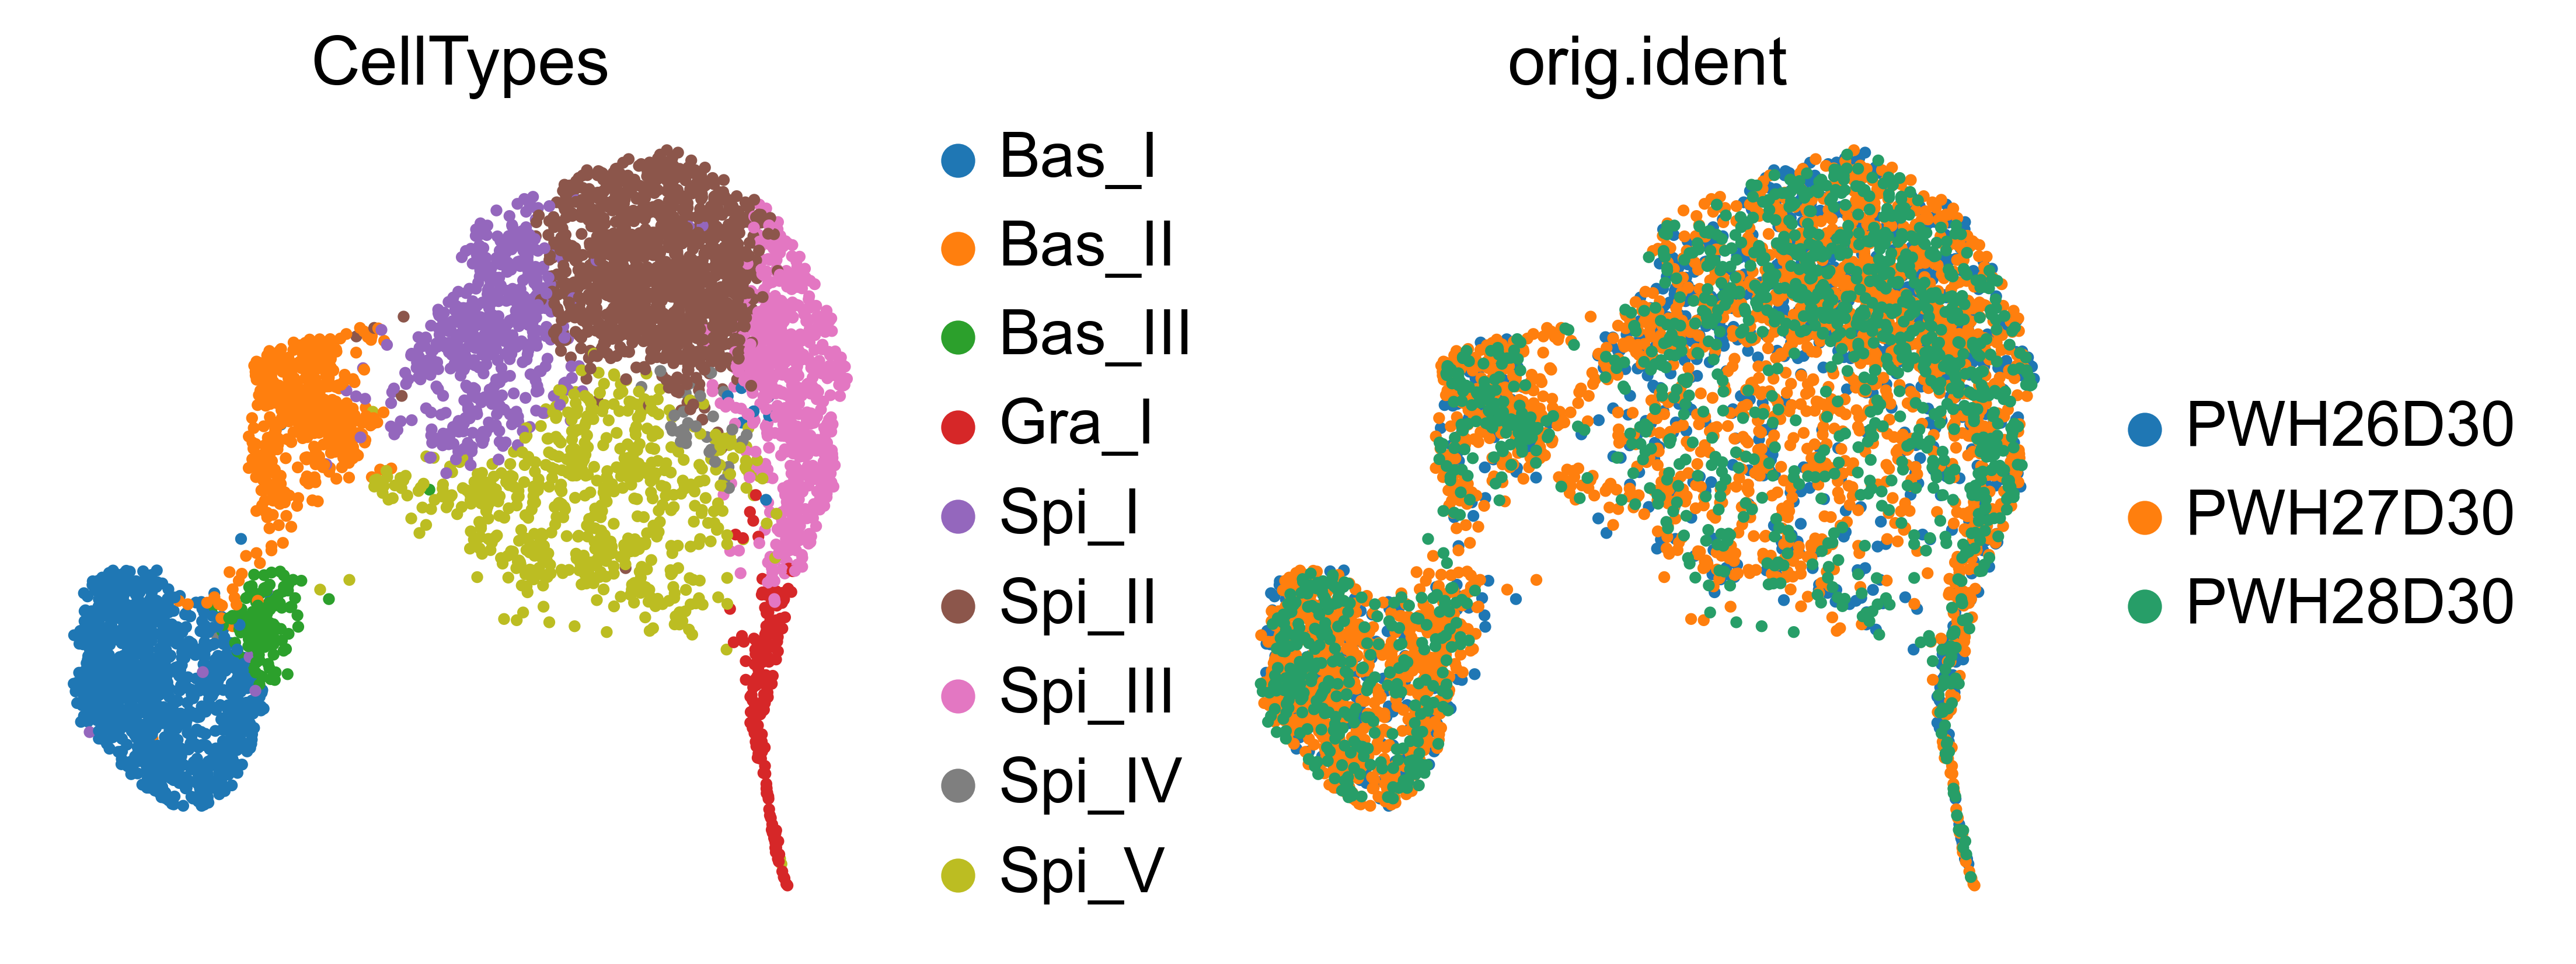

In [25]:
sc.pl.umap(adata, color=['CellTypes', 'orig.ident'], legend_loc='right margin')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing Diffusion Maps using n_comps=3(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.        0.9923708 0.9878746]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:35)


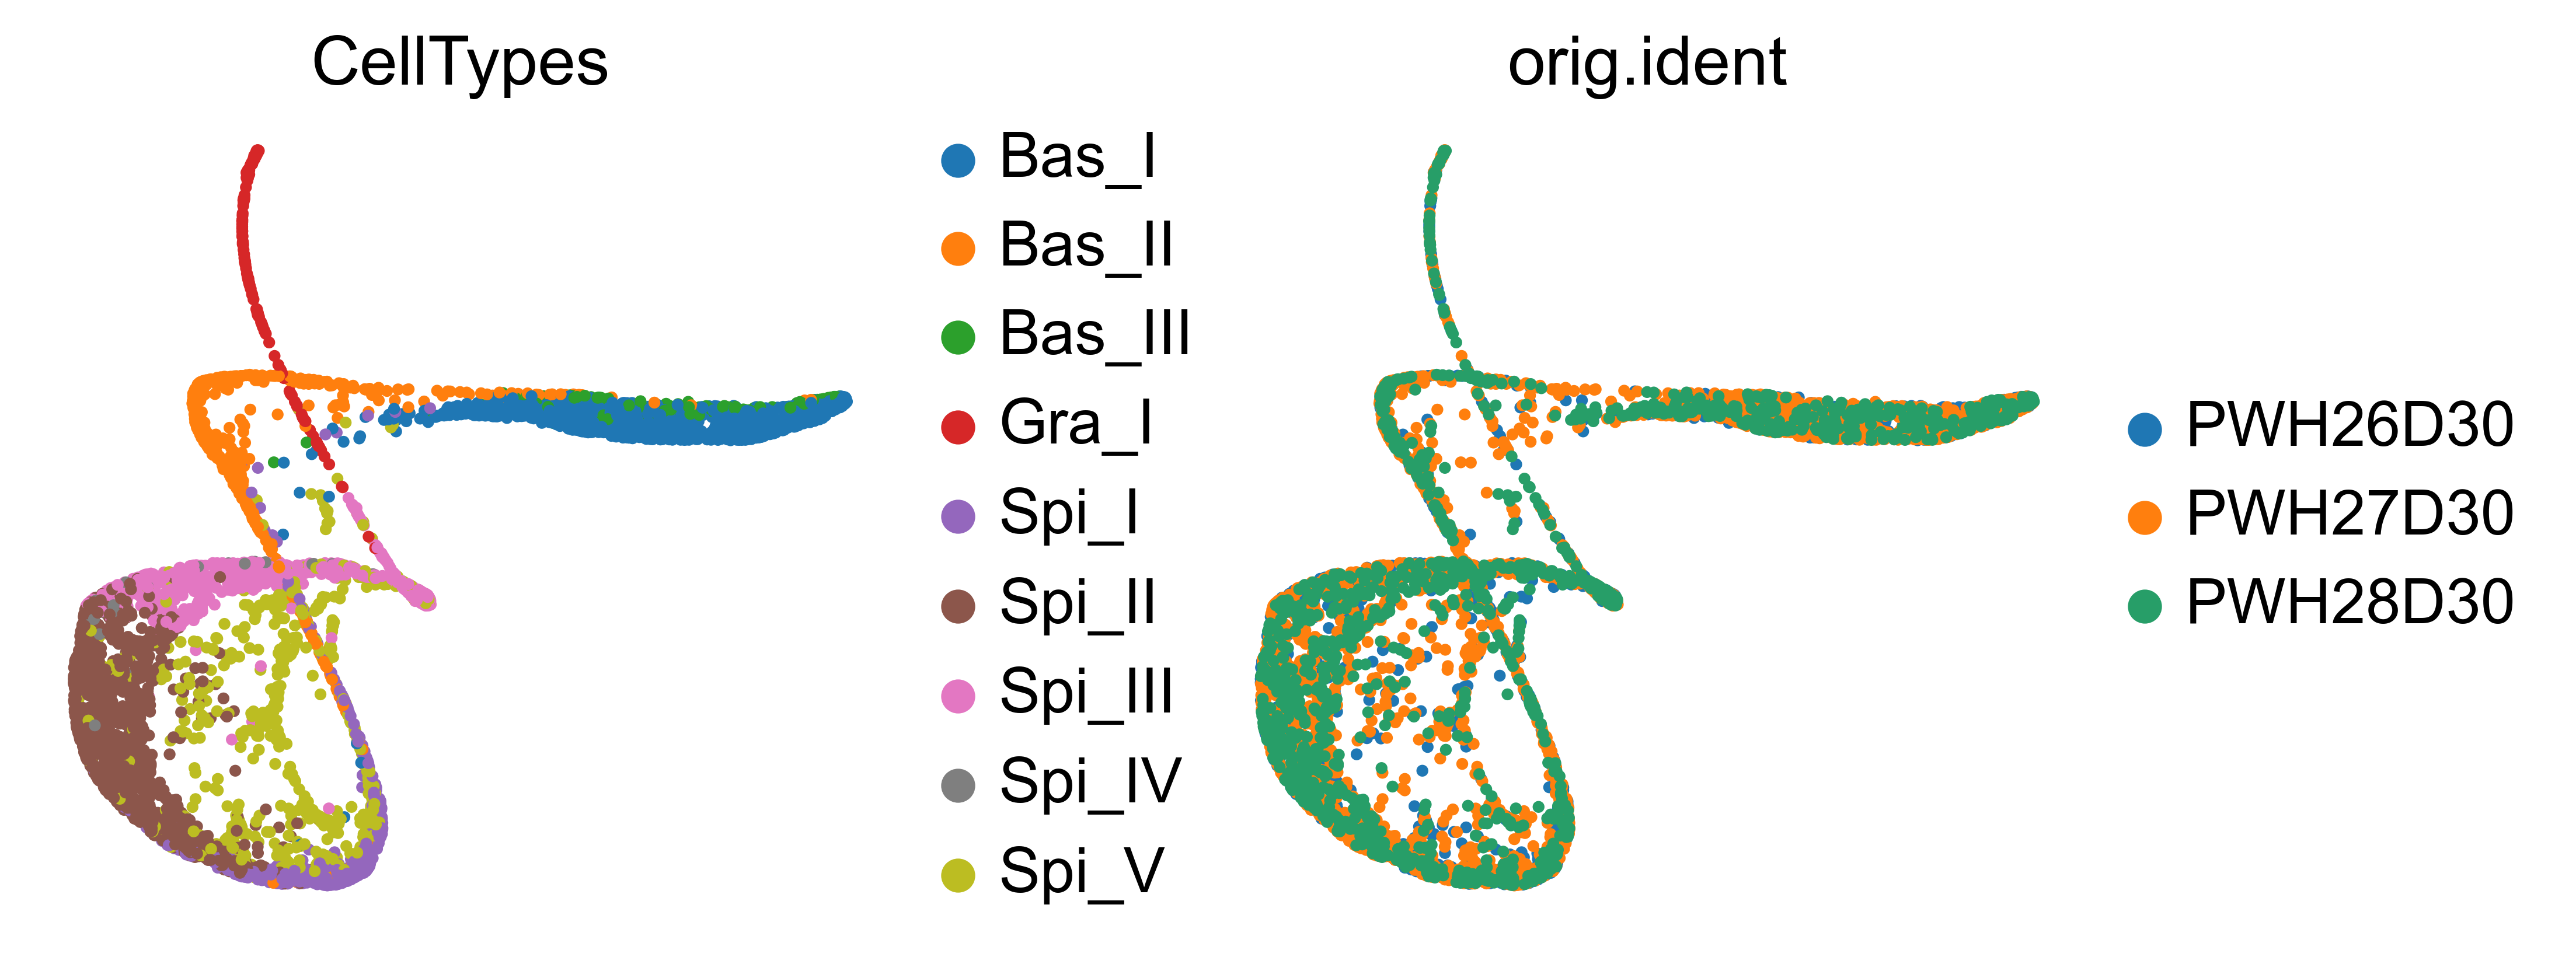

In [26]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=15, use_rep = "X_harmony")

sc.tl.diffmap(adata, n_comps=3)

sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_diffmap')
sc.tl.draw_graph(adata, n_jobs=6, layout='fa')
sc.pl.draw_graph(adata, color=['CellTypes', 'orig.ident'], legend_loc='right margin')

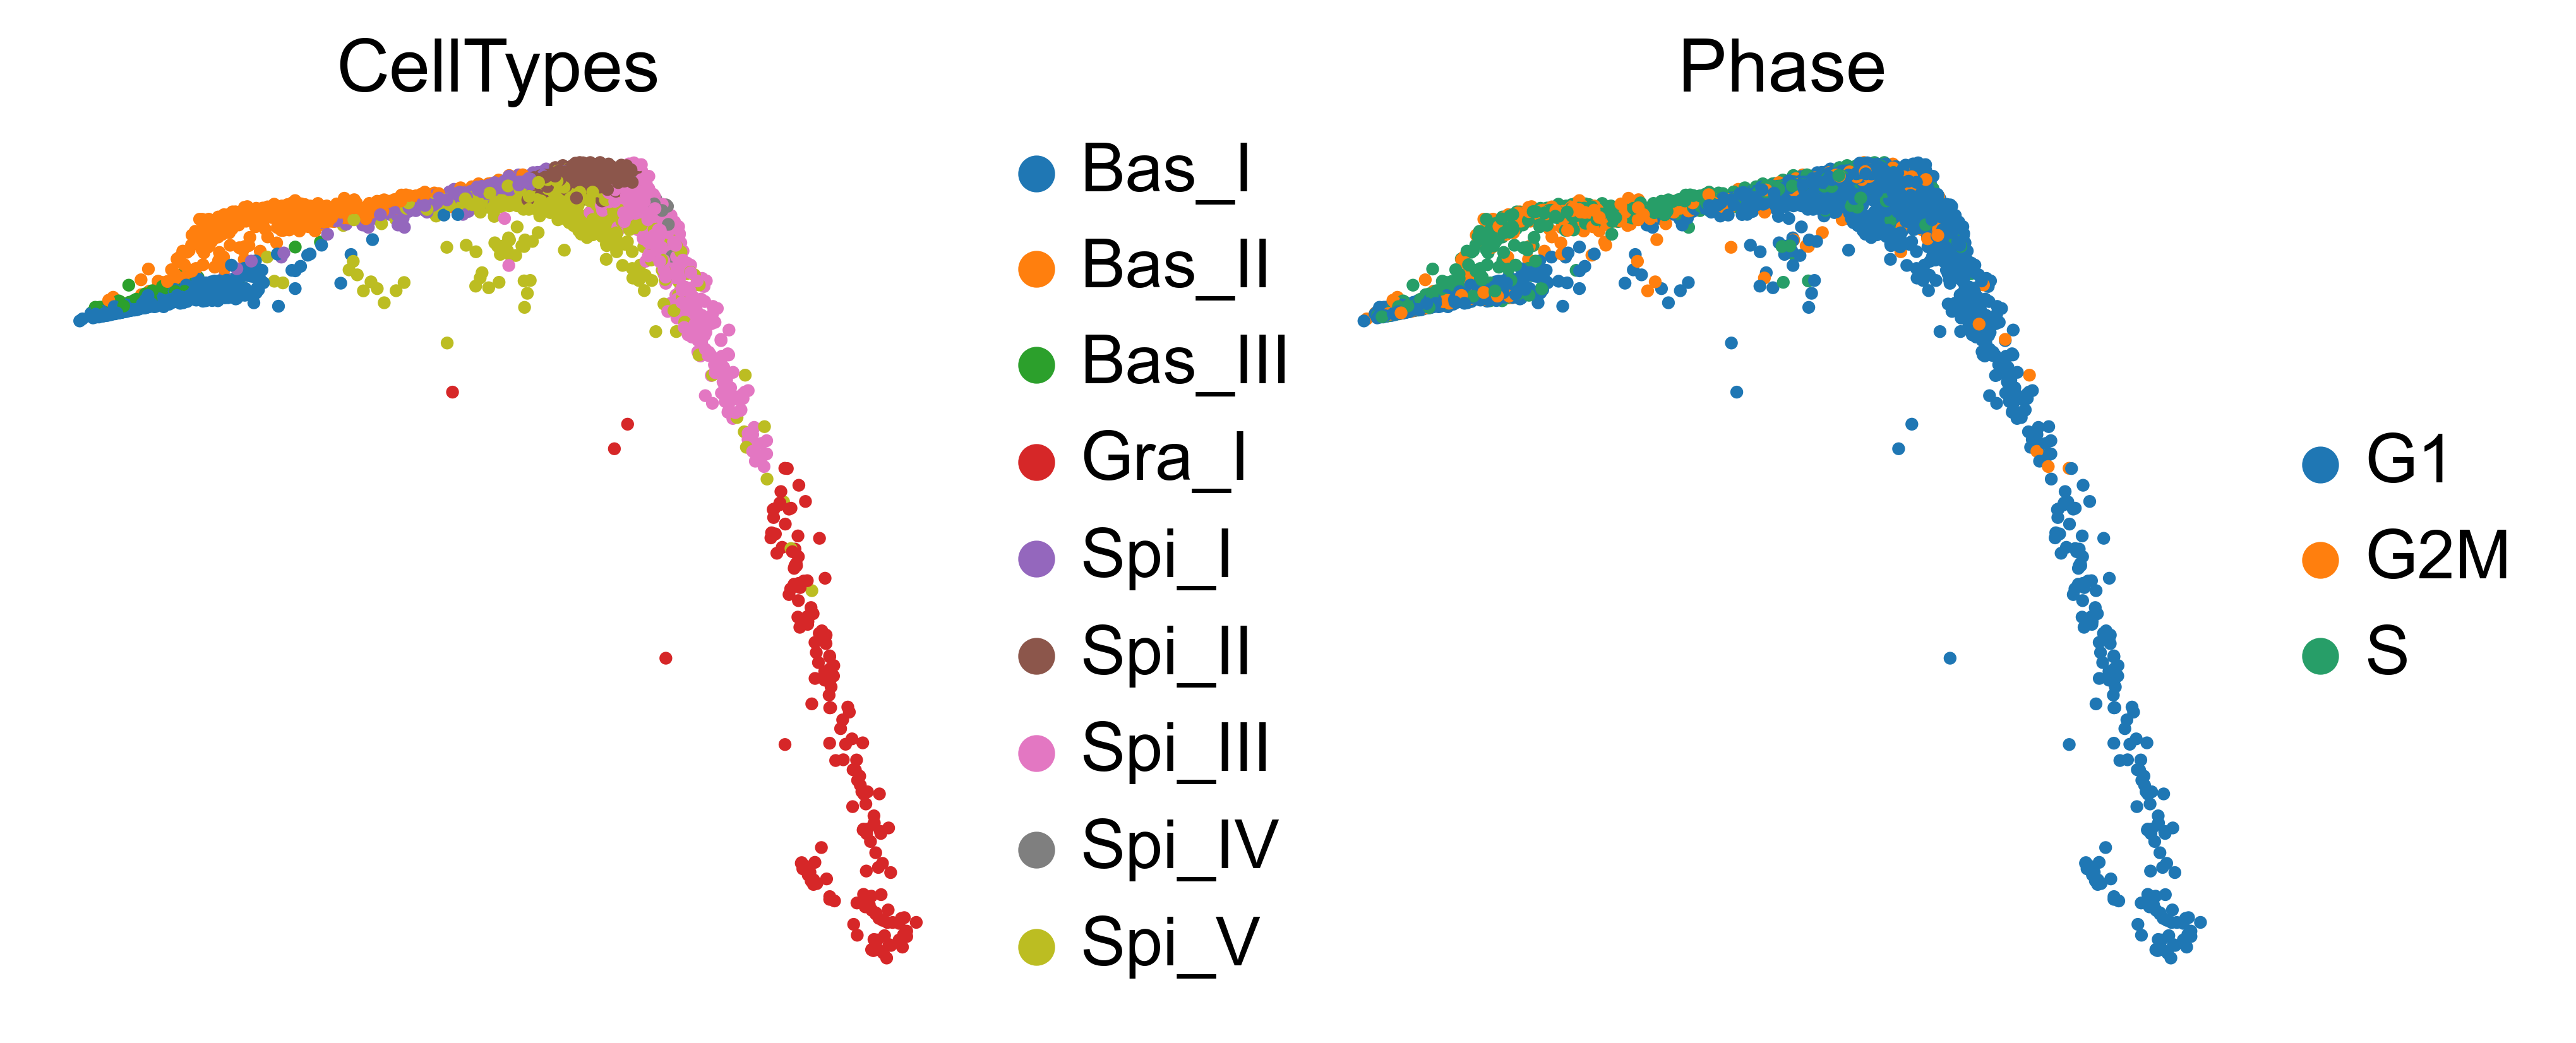

In [27]:
# Seurat
sc.pl.diffmap(adata, color=['CellTypes', 'Phase'], components=[1, 2], projection='2d', edges_width=0.5)

In [28]:
#sc.tl.louvain(adata, resolution=0.5)
sc.tl.paga(adata, groups='CellTypes', model='v1.2')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


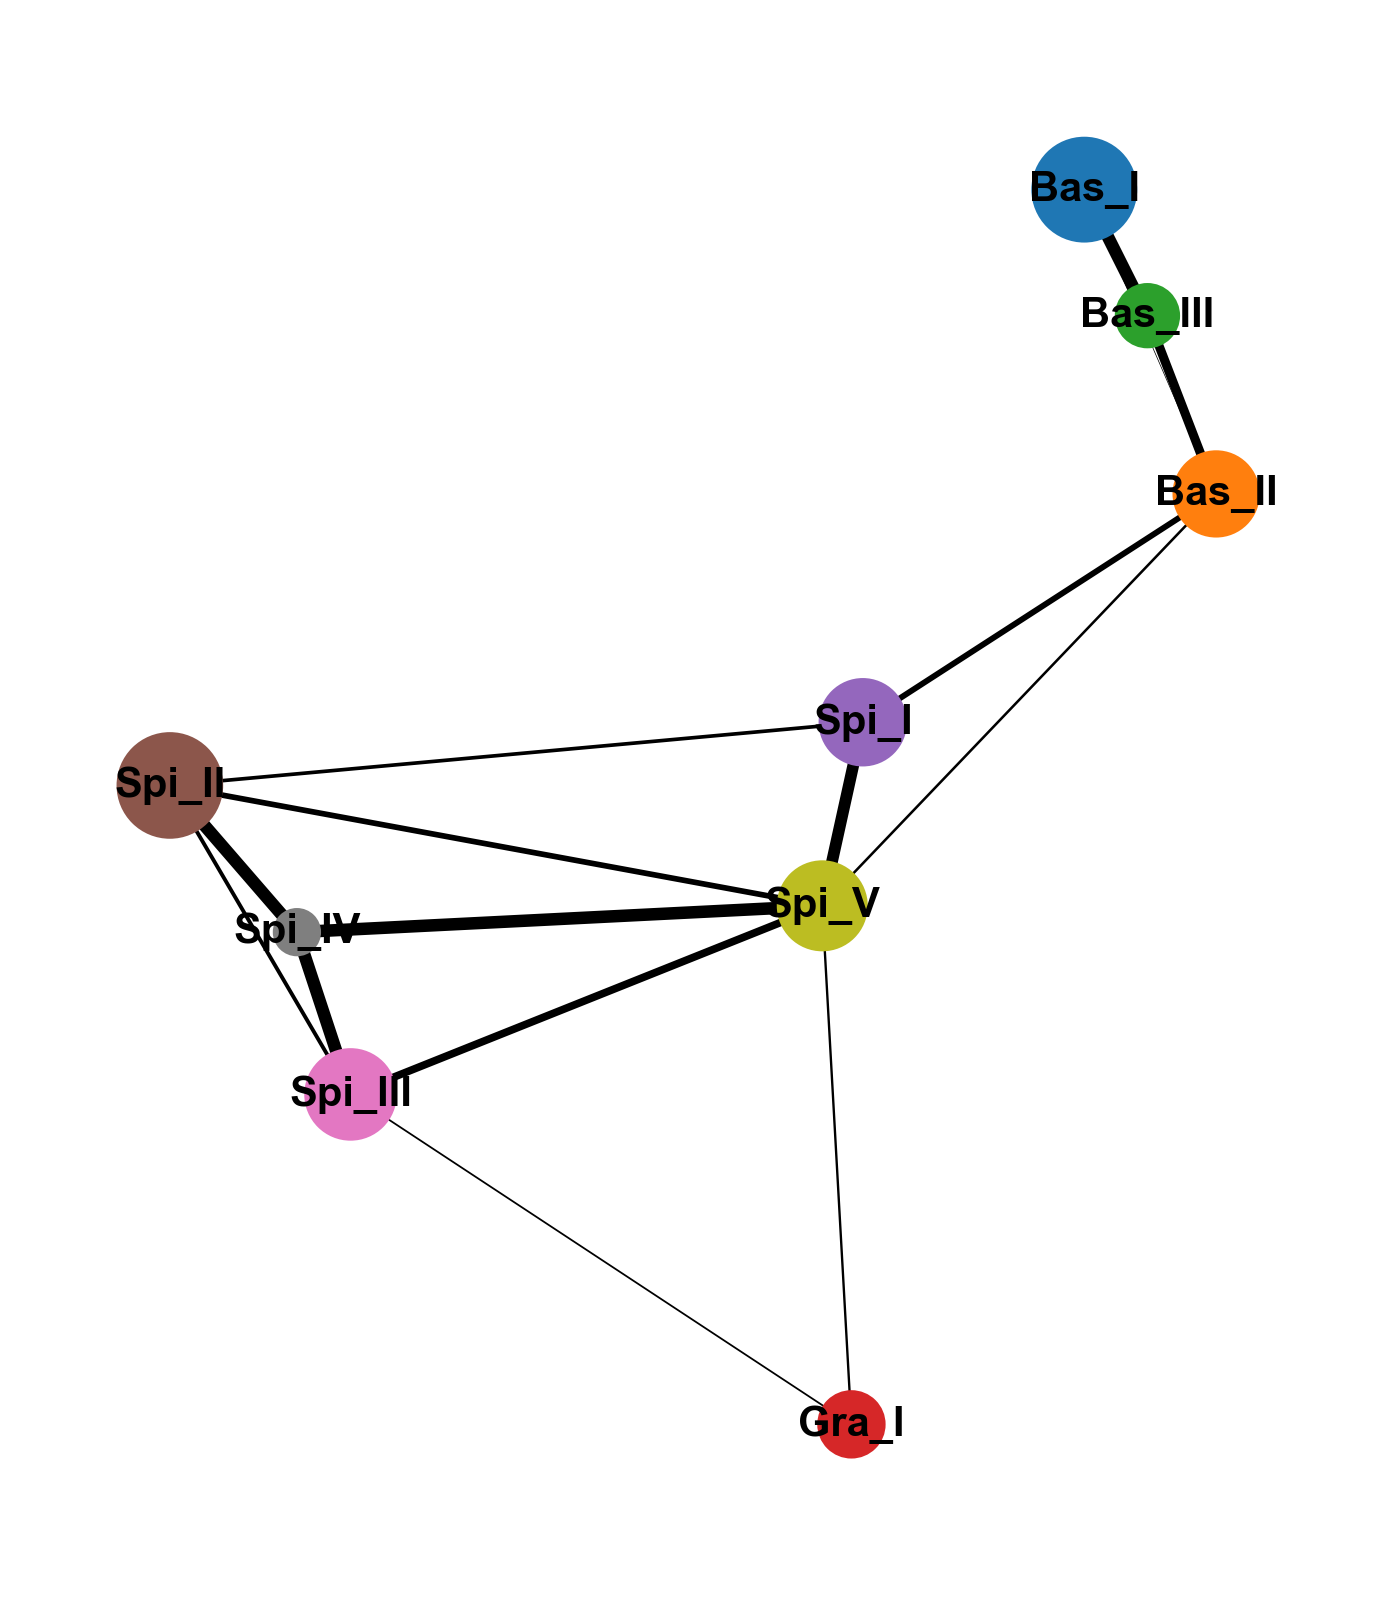

In [29]:
# Seurat
sc.pl.paga(adata, color=['CellTypes'], layout='fa', #‘fa’, ‘fr’, ‘rt’, ‘rt_circular’, ‘drl’, ‘eq_tree’
           node_size_scale=0.6, edge_width_scale=0.2, fontsize=5, frameon=False,
           threshold=0.05)

In [30]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['CellTypes'] == 'Bas_I')[0]
sc.tl.dpt(adata, n_branchings=0, n_dcs=3)

computing Diffusion Pseudotime using n_dcs=3
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


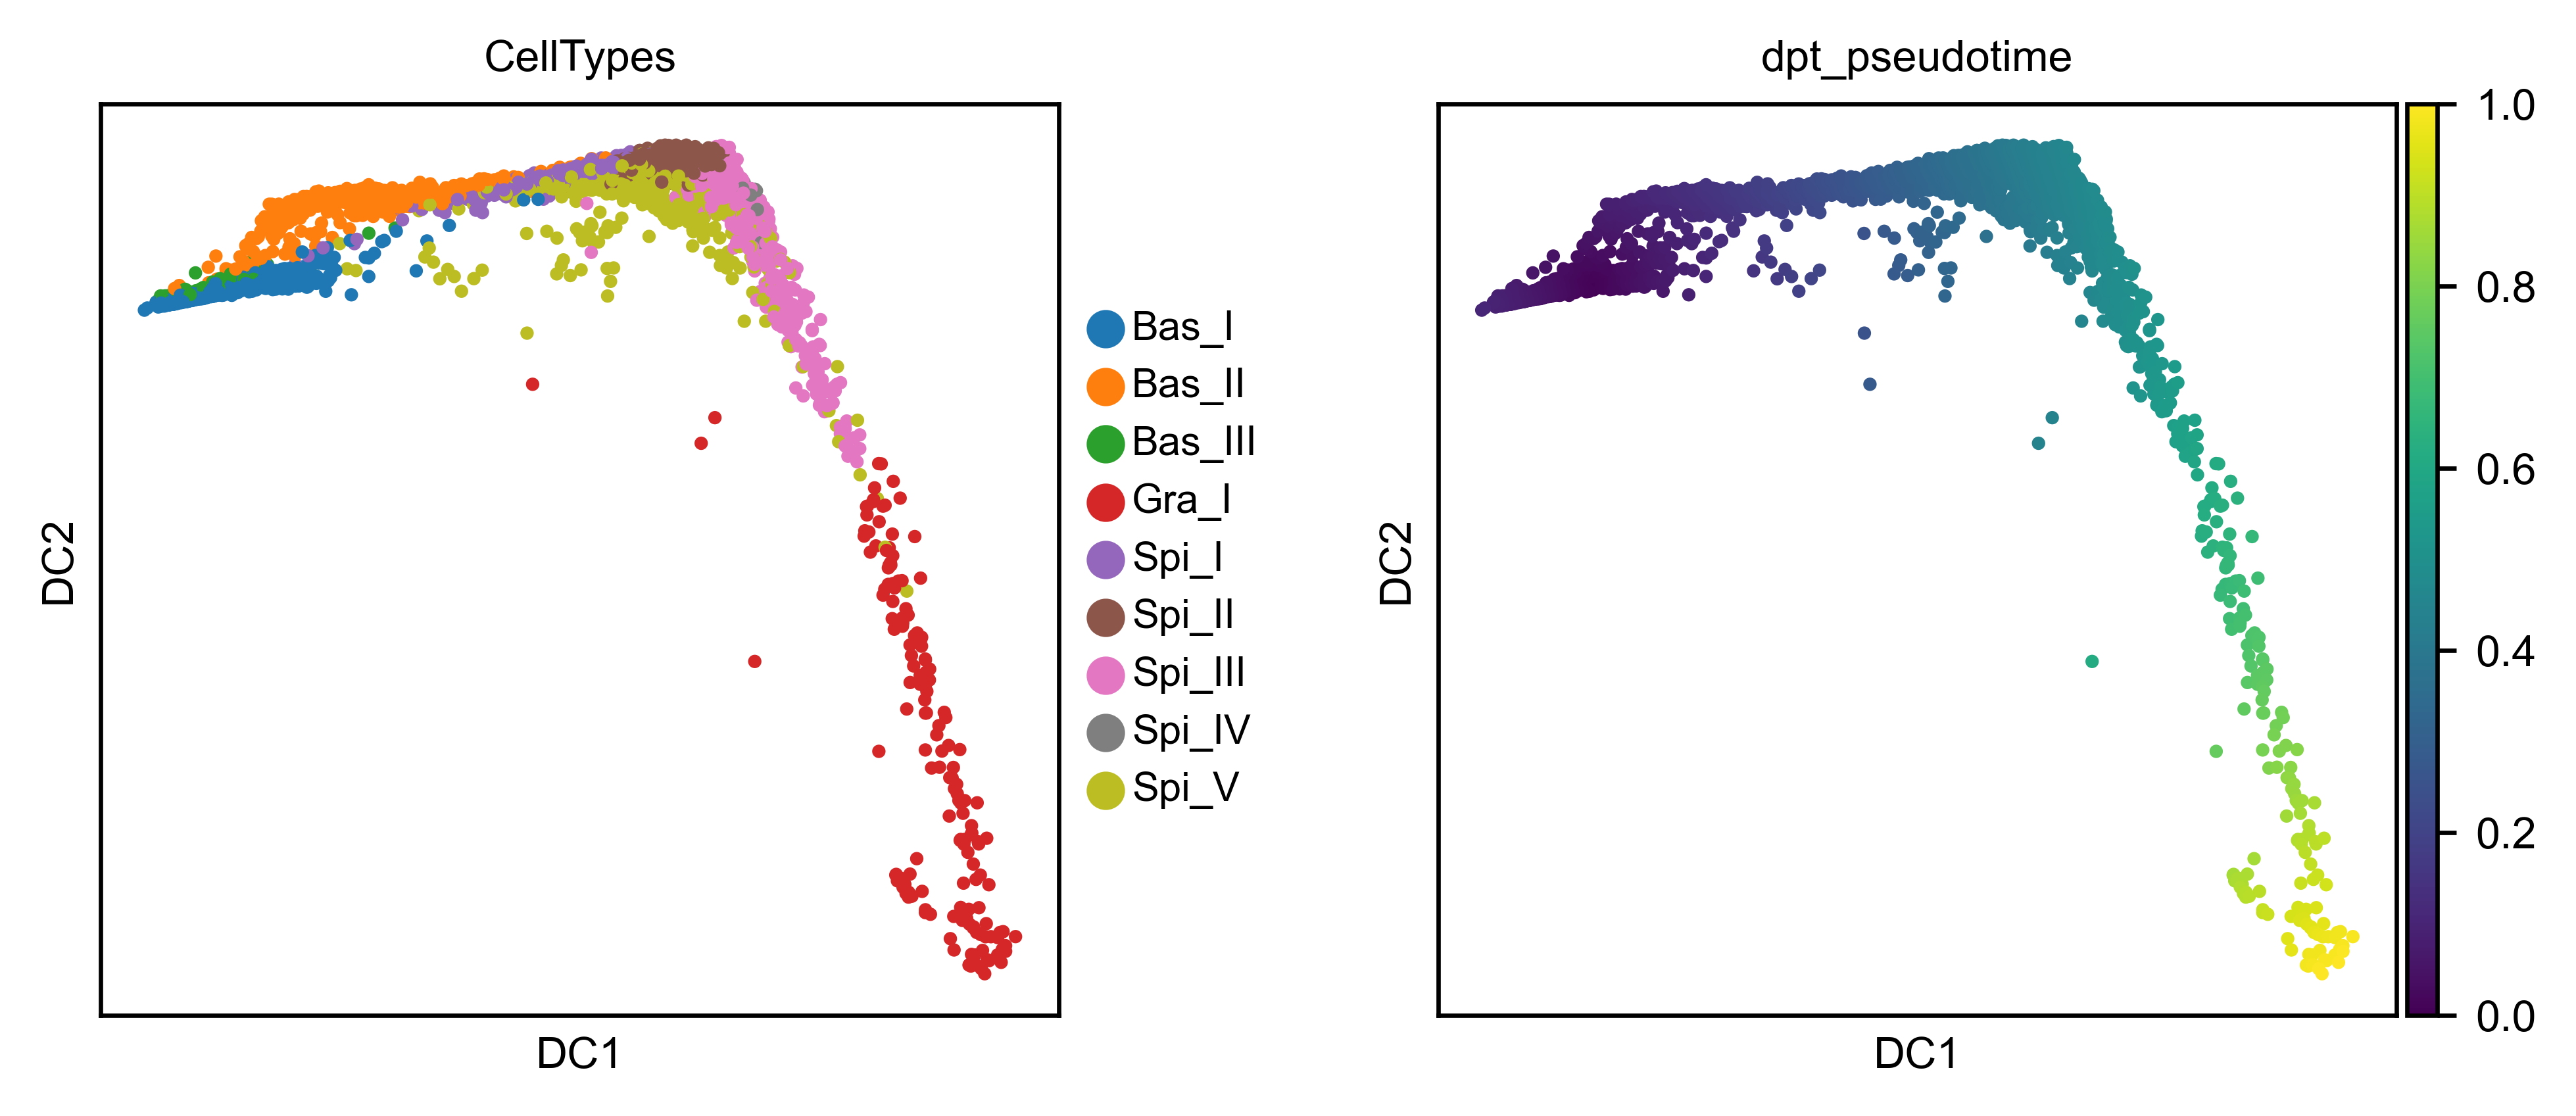

In [31]:
#sc.set_figure_params(dpi=160, color_map='viridis', fontsize=8)
#sc.pl.embedding(adata, basis='diffmap', color=['CellTypes'],
#                legend_loc='right margin', legend_fontsize=5)

#sc.pl.diffmap(adata, color=['dpt_pseudotime', 'dpt_groups', 'CellTypes'])
sc.set_figure_params(dpi=300, color_map='viridis', fontsize=8, figsize=(3, 3))
sc.pl.diffmap(adata, color=['CellTypes', 'dpt_pseudotime'], components=[1,2], projection='2d') 

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:48)
computing Diffusion Pseudotime using n_dcs=3
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


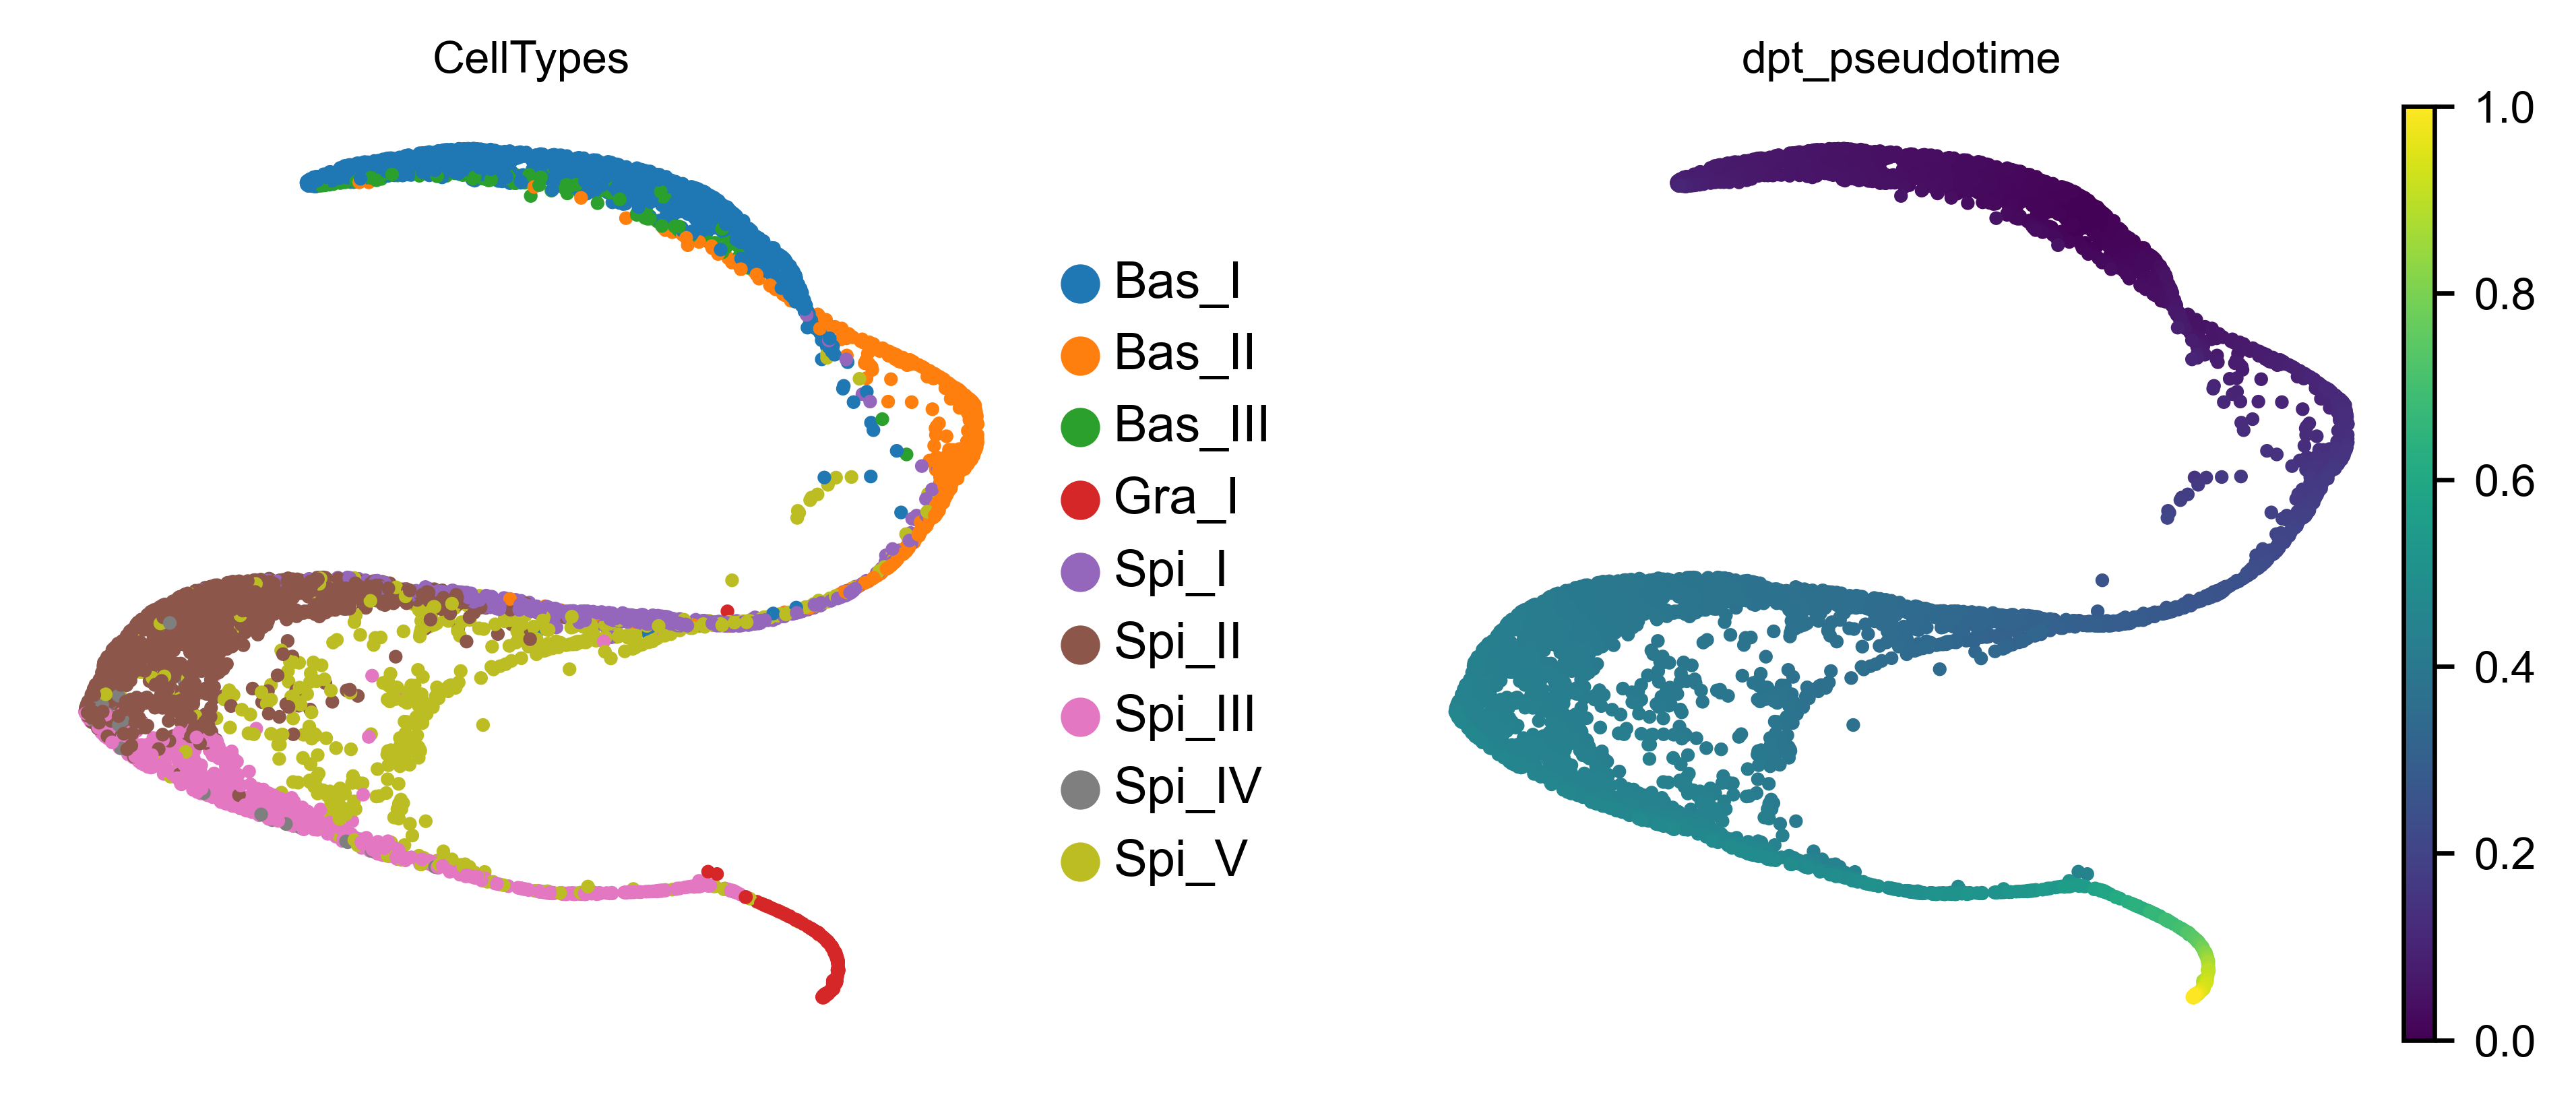

In [32]:
sc.tl.draw_graph(adata, init_pos='paga')
adata.uns['iroot'] = np.flatnonzero(adata.obs['CellTypes'] == 'Bas_I')[0]
sc.tl.dpt(adata, n_branchings=0, n_dcs=3)
sc.pl.draw_graph(adata, color=['CellTypes', 'dpt_pseudotime'], legend_loc='right margin', frameon=False, legend_fontsize=9, projection='2d')

In [33]:
## save
#adata.write(f"{oDir}/{stype}_Treg.sc.h5ad")
diff = pd.DataFrame(adata.obsm['X_diffmap'], index=adata.obs_names)
diff.to_csv("DPT_wound30_diffMap.txt", sep="\t")
adata.obs.loc[:,["CellTypes","dpt_pseudotime"]].to_csv("DPT_wound30_dpt_pseudotime.txt", sep="\t")

# RNA Velocity

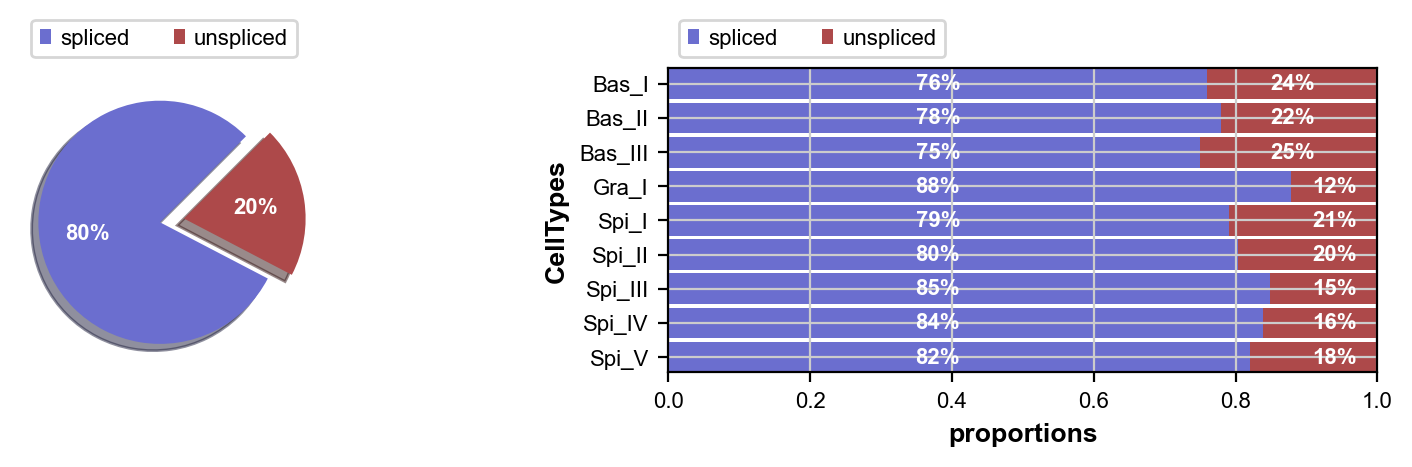

In [34]:
# the proportion of spliced and unspliced transcripts in each of our cell clusters. 
scv.pl.proportions(adata, groupby='CellTypes')

In [35]:
# pre-process
scv.pp.filter_and_normalize(adata, min_shared_counts=20, min_shared_cells=30, log=True, enforce=True, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=15, n_neighbors=30)

# compute velocity
scv.tl.recover_dynamics(adata, n_jobs=6) #If using dynamical model
scv.tl.velocity(adata, mode='dynamical') #, deterministic, stochastic, dynamical
scv.tl.velocity_graph(adata)

Filtered out 17694 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 6/12 cores)


/Users/zhuliu/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/zhuliu/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:06:51) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:11) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/zhuliu/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:23) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:02) --> added
    'velocity_diffmap', embedded velocity vectors (adata.obsm)


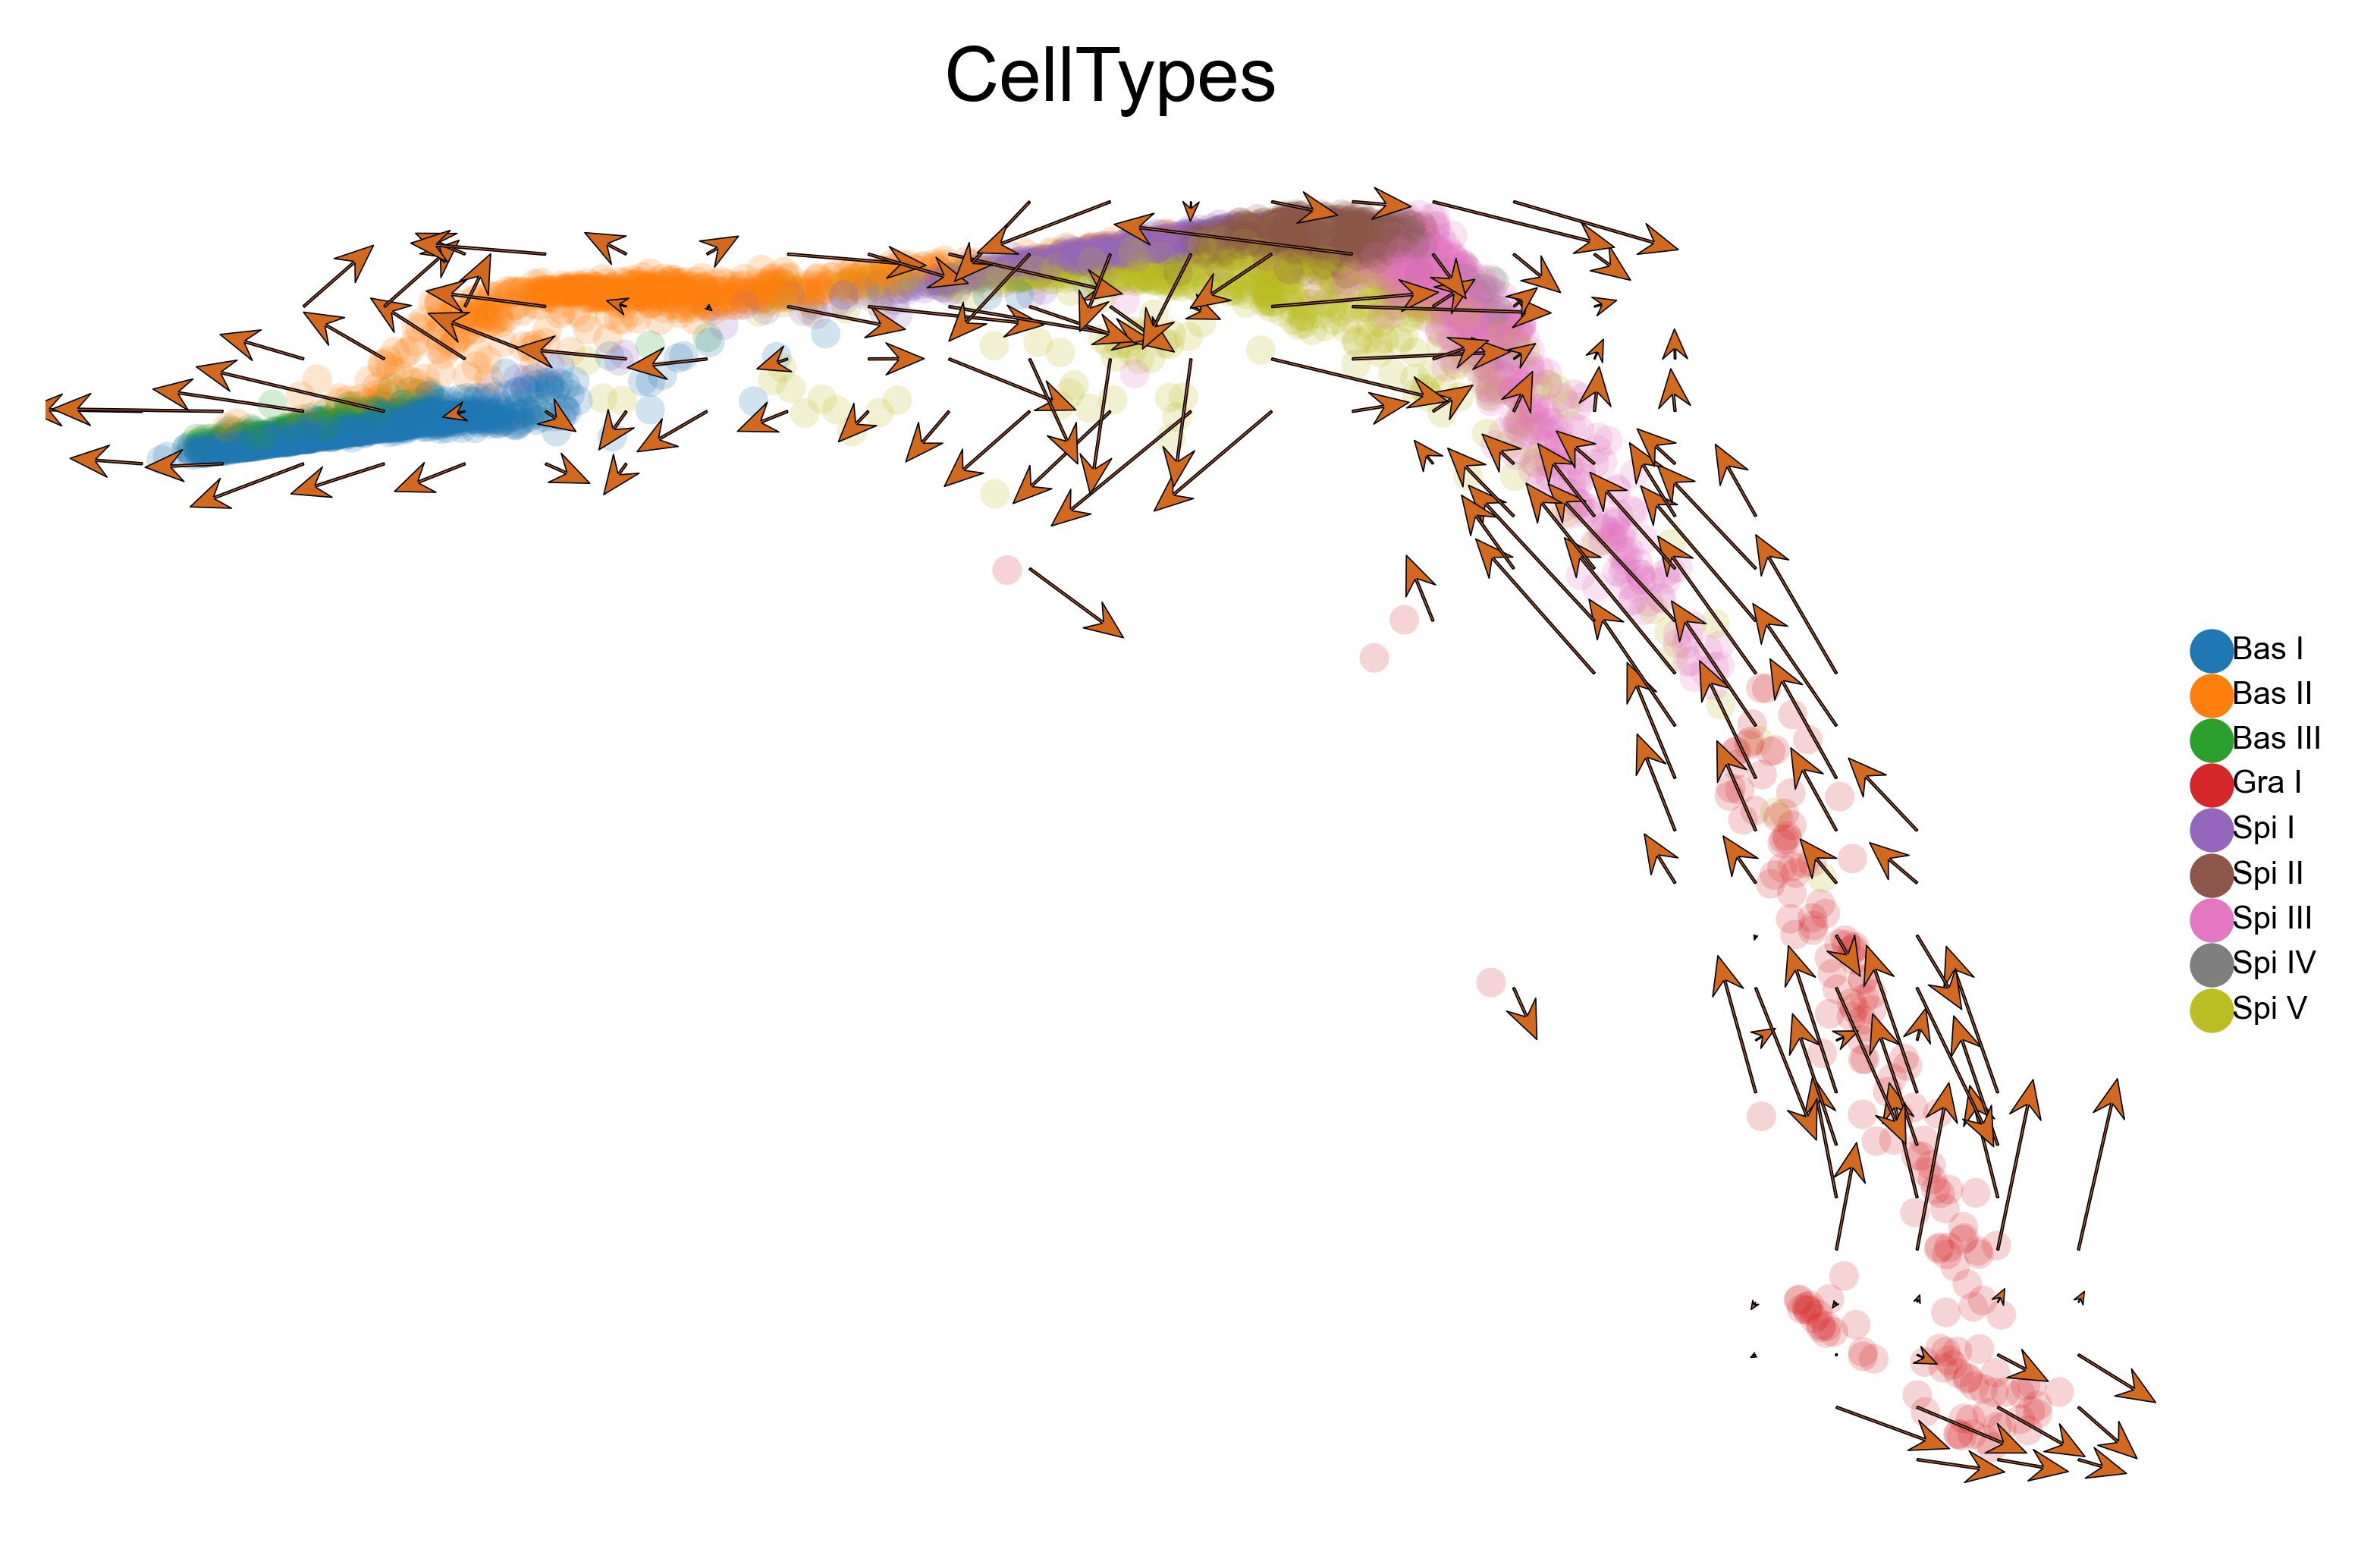

In [36]:
scv.settings.set_figure_params('scvelo', dpi=300)
scv.pl.velocity_embedding_grid(adata, basis='diffmap',color='CellTypes',arrow_size=3, arrow_length=3,
                               density=0.5, arrow_color="#D2691E", 
                               legend_loc='right margin',legend_fontsize=5)

In [37]:
# pre-process
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=15, n_neighbors=30)

computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [38]:
# Import the kernel and initialize it using the pre-processed AnnData object
from cellrank.tl.kernels import PseudotimeKernel
pk=PseudotimeKernel(adata, time_key='dpt_pseudotime')
print(pk)

<PseudotimeKernel>


In [39]:
pk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)
pk.compute_projection(basis="diffmap")

100%|███████████████████████████████████████████████████████████████████████████| 5033/5033 [00:03<00:00, 1578.44cell/s]


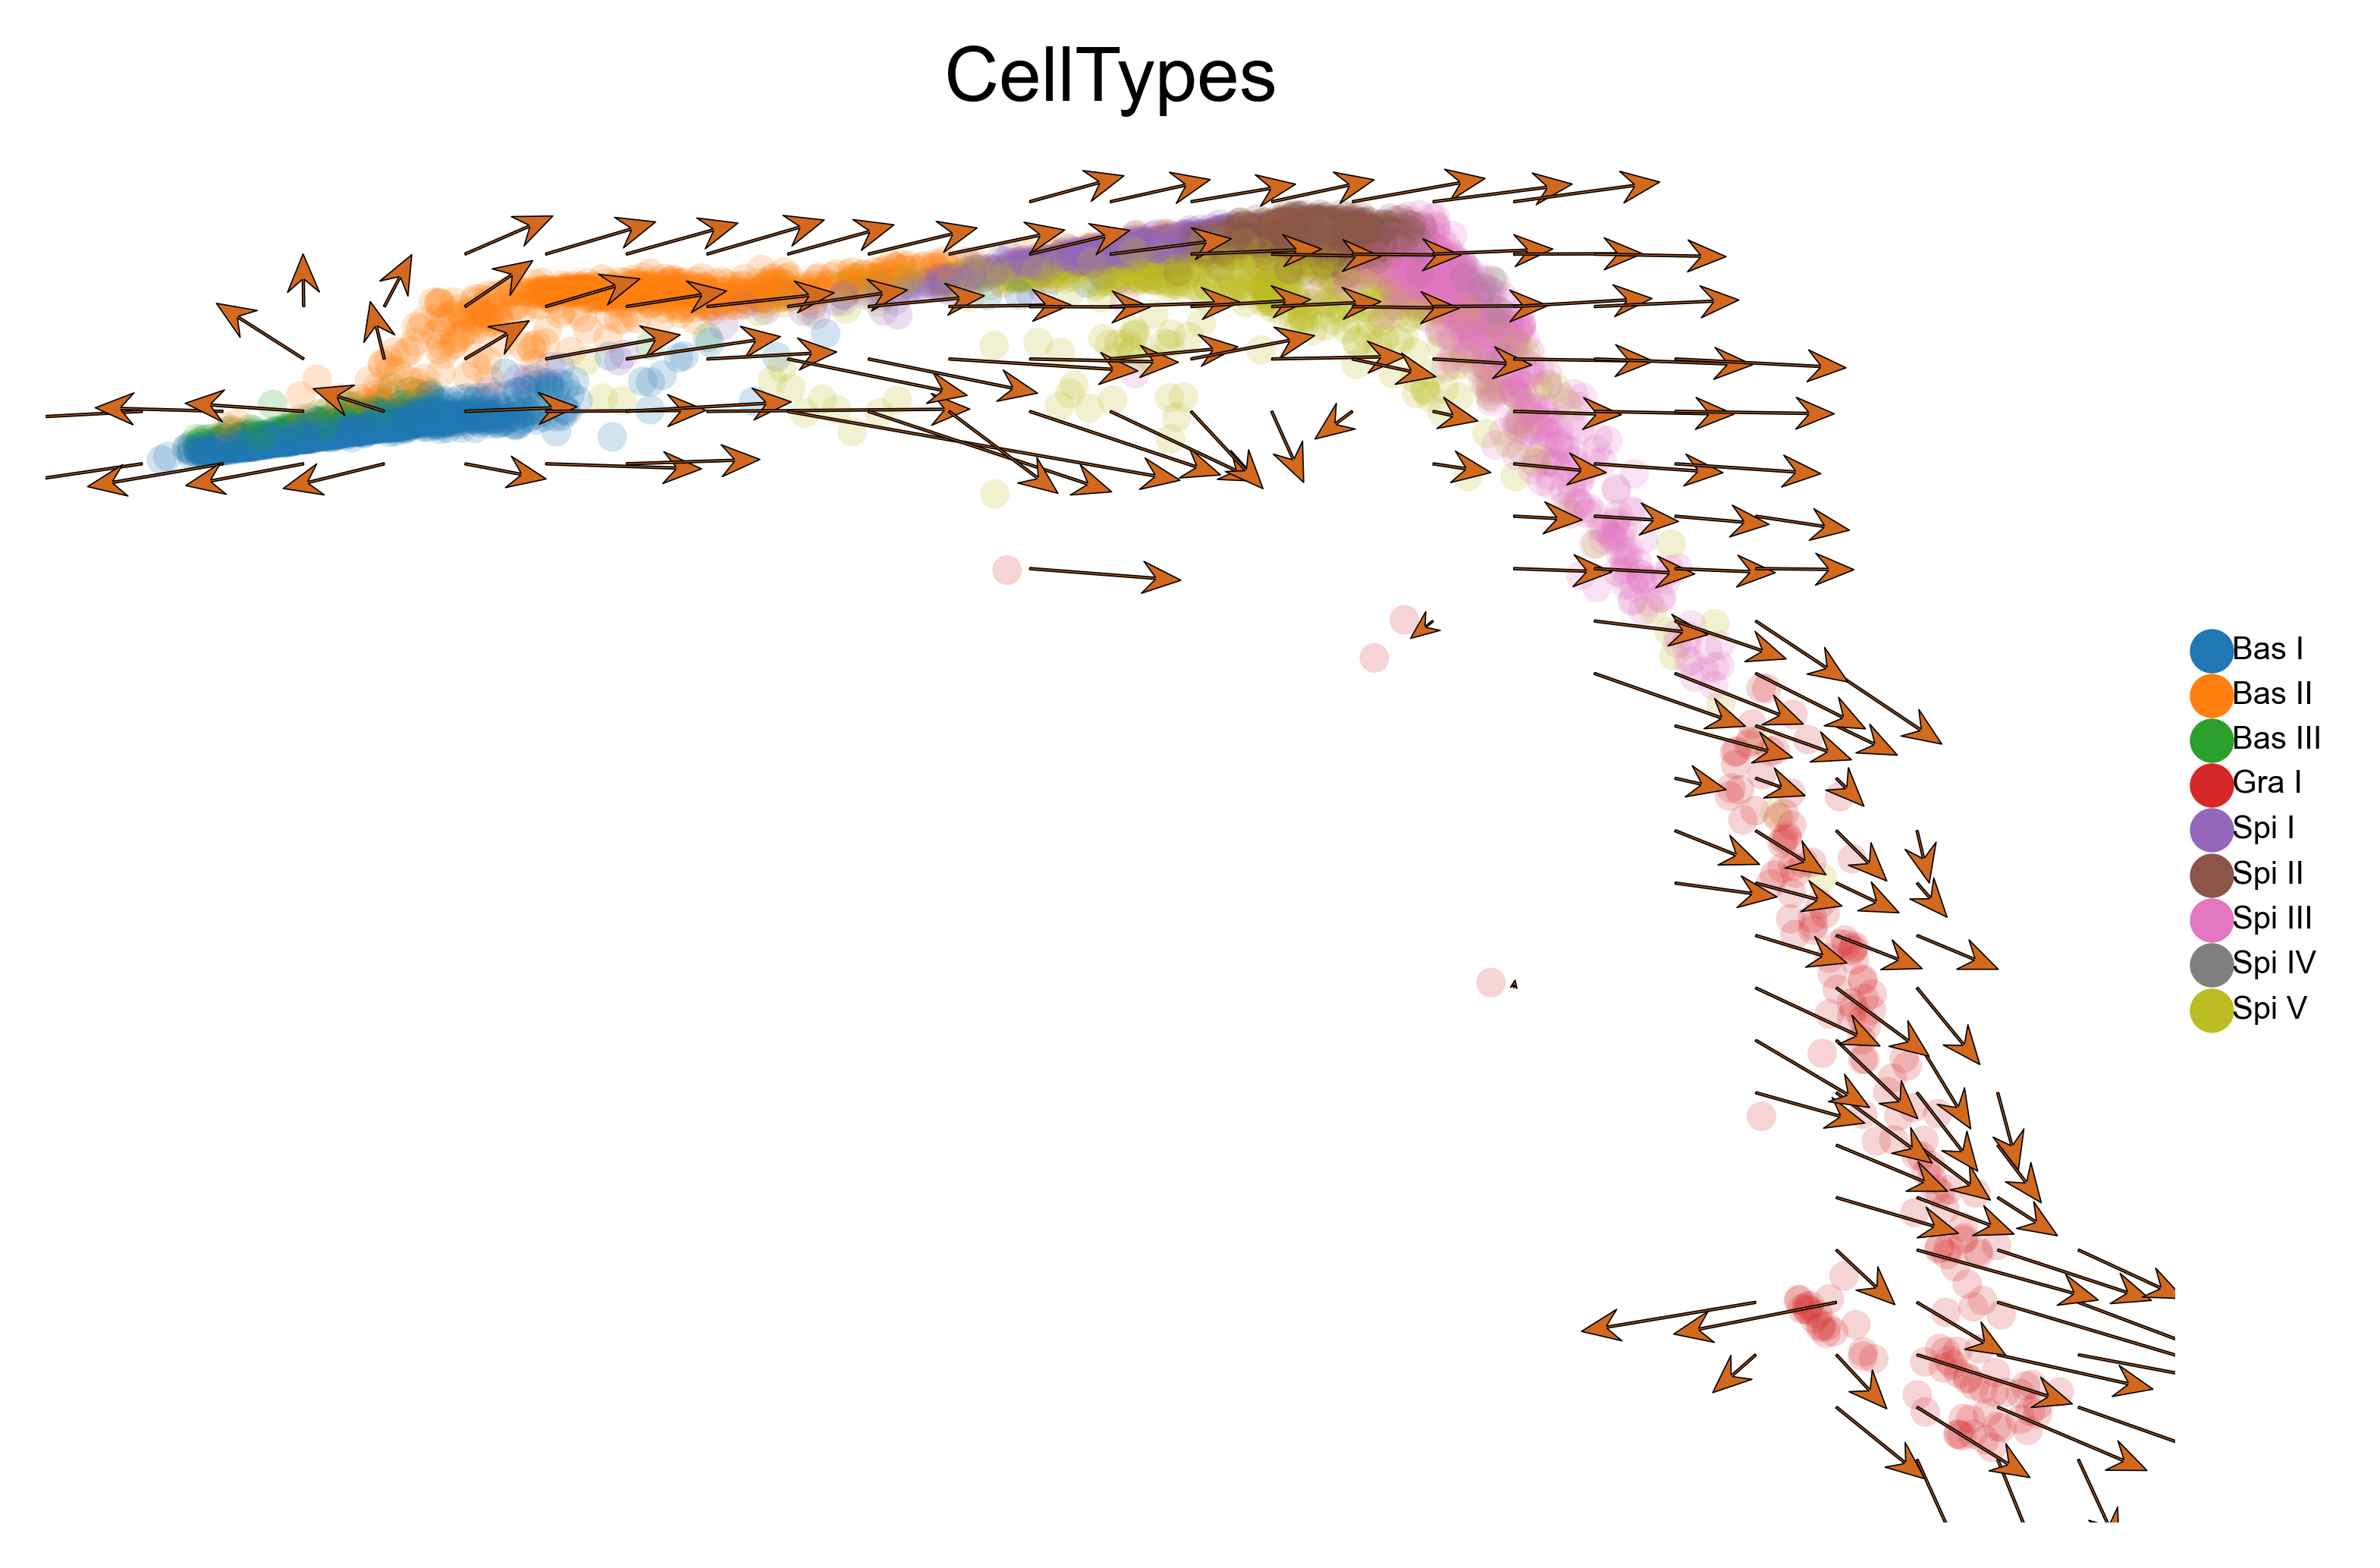

In [40]:
scv.settings.set_figure_params('scvelo', dpi=300)
scv.pl.velocity_embedding_grid(adata, basis='diffmap',color=['CellTypes'],arrow_size=3, arrow_length=3,
                               density=0.5, arrow_color="#D2691E", vkey="T_fwd", 
                               legend_loc='right margin',legend_fontsize=5)